<a href="https://colab.research.google.com/github/etuckerman/LTSM_Crypto_Prediction/blob/main/LSTM_Crypto_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
50/50 [==============================] - 7s 35ms/step - loss: 0.1773 - val_loss: 0.0821
Epoch 2/50
50/50 [==============================] - 0s 9ms/step - loss: 0.1037 - val_loss: 0.0771
Epoch 3/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0962 - val_loss: 0.0757
Epoch 4/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0911 - val_loss: 0.0748
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0876 - val_loss: 0.0750
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0851 - val_loss: 0.0754
Epoch 7/50
50/50 [==============================] - 0s 9ms/step - loss: 0.0844 - val_loss: 0.0754
Epoch 8/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0835 - val_loss: 0.0750
Epoch 9/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0834 - val_loss: 0.0751
Epoch 10/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0833 - val_loss: 0.0751
Epoch 11/50


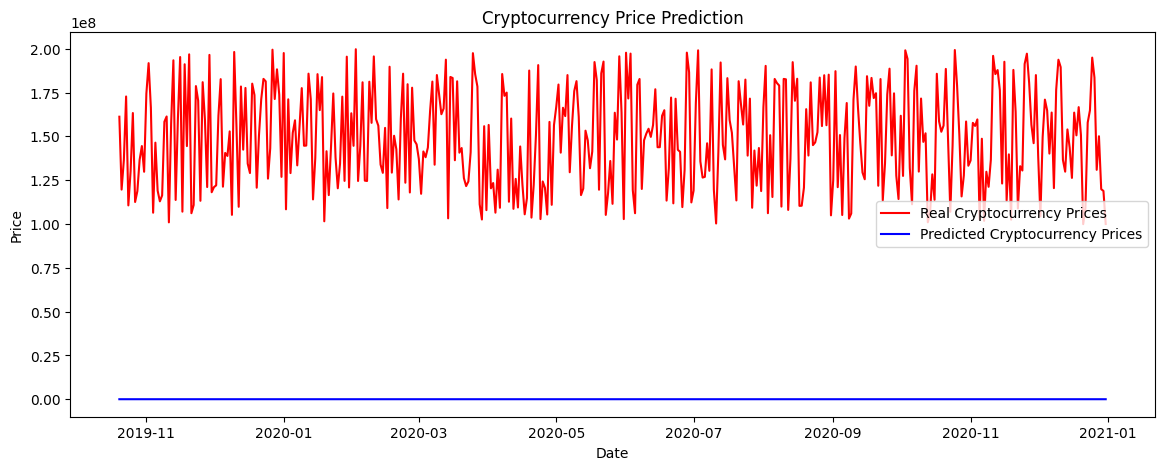

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Sample data generation
np.random.seed(0)
dates = pd.date_range(start='2015-01-01', end='2020-12-31', freq='D')
n = len(dates)

# Generate opening prices
opening_prices = np.cumsum(np.random.randn(n)) + 100

# Create DataFrame after opening prices have been generated
data = pd.DataFrame({
    'date': dates,
    'opening_price': opening_prices,
    'highest_price': opening_prices + np.random.randn(n) * 5,
    'lowest_price': opening_prices - np.random.randn(n) * 5,
    'closing_price': opening_prices + np.random.randn(n),
    'trading_volume': np.random.randint(10000, 20000, n)
})

# Display the first few rows of the DataFrame
data.head()

# Set the number of features (excluding the date column)
num_features = len(data.columns) - 2

# Convert the data to a numpy array, excluding the date column
dataset = data.drop(columns=['date']).to_numpy()

# Split the data into training and testing sets
train_size = int(0.8 * n)
train_data, test_data = dataset[:train_size, :], dataset[train_size:, :]

# Split the training data into input and output sets
train_input, train_output = train_data[:, :-1], train_data[:, -1]

# Scale the data (to ensure that all features have similar scales)
scaler = MinMaxScaler()
columns_to_scale = ['opening_price', 'highest_price', 'lowest_price', 'closing_price', 'trading_volume']
train_input_scaled = scaler.fit_transform(train_data[:, :-1])
scaler_output = MinMaxScaler().fit(train_data[:, -1].reshape(-1, 1))  # Fit scaler to the output separately

# Reshape the training input data to fit the LSTM input shape (samples, time steps, features)
train_input_scaled = np.reshape(train_input_scaled, (train_input_scaled.shape[0], 1, num_features))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(train_input_scaled.shape[1], num_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(train_input_scaled, scaler_output.transform(train_output.reshape(-1, 1)), epochs=50, batch_size=32, validation_split=0.1)

# Scale the test data
test_input, test_output = test_data[:, :-1], test_data[:, -1]
test_input_scaled = scaler.transform(test_input)

# Reshape the test input data to fit the LSTM input shape (samples, time steps, features)
test_input_scaled = np.reshape(test_input_scaled, (test_input_scaled.shape[0], 1, num_features))

# Make predictions
test_predictions_scaled = model.predict(test_input_scaled)

# Inverse scale the predictions
test_predictions_unscaled = scaler_output.inverse_transform(test_predictions_scaled).flatten()

# Inverse scale the test output
test_output_unscaled = scaler_output.inverse_transform(test_output.reshape(-1, 1)).flatten()

# Calculate the mean absolute error
mae = np.mean(np.abs(test_predictions_unscaled - test_output_unscaled))
print(f"Test MAE: {mae:.2f}")

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(data['date'][train_size:], test_output_unscaled, color='red', label='Real Cryptocurrency Prices')
plt.plot(data['date'][train_size:], test_predictions_unscaled, color='blue', label='Predicted Cryptocurrency Prices')
plt.title('Cryptocurrency Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
